In [1]:
import os
import uproot
import numpy as np

def load_root_file(file_path, branches=None, print_branches=False):
    all_branches = {}
    with uproot.open(file_path) as file:
        tree = file["tree"]
        # Load all ROOT branches into array if not specified
        if branches is None:
            branches = tree.keys()
        # Option to print the branch names
        if print_branches:
            print("Branches:", tree.keys())
        # Each branch is added to the dictionary
        for branch in branches:
            try:
                all_branches[branch] = (tree[branch].array(library="np"))
            except uproot.KeyInFileError as e:
                print(f"KeyInFileError: {e}")
        # Number of events in file
        all_branches['event'] = tree.num_entries
    return all_branches

branches_list = [
    't5_innerRadius',
    't5_bridgeRadius',
    't5_outerRadius',
    't5_pt',
    't5_eta',
    't5_phi',
    't5_isFake',
    't5_t3_idx0',
    't5_t3_idx1',
    't5_pMatched',
    't5_sim_vxy',
    't5_sim_vz'
]

# Hit-dependent branches
suffixes = ['r', 'z', 'eta', 'phi', 'layer']
branches_list += [f't5_t3_{i}_{suffix}' for i in [0, 2, 4] for suffix in suffixes]

file_path = "1000_no_dnn_nodbeta2_phi.root"
branches = load_root_file(file_path, branches_list)

In [2]:
z_max = np.max([np.max(event) for event in branches[f't5_t3_4_z']])
r_max = np.max([np.max(event) for event in branches[f't5_t3_4_r']])
eta_max = 2.5
phi_max = np.pi

print(f'Z max: {z_max}, R max: {r_max}, Eta max: {eta_max}')

def delta_phi(phi1, phi2):
    delta = phi1 - phi2
    # Adjust delta to be within the range [-pi, pi]
    if delta > np.pi:
        delta -= 2 * np.pi
    elif delta < -np.pi:
        delta += 2 * np.pi
    return delta

Z max: 267.2349853515625, R max: 110.10993957519531, Eta max: 2.5


In [3]:
features_list = []
eta_list = [] # Used for DNN cut values

for event in range(branches['event']):
    # Determine the number of elements in this event
    num_elements = len(branches['t5_t3_idx0'][event])

    for i in range(num_elements):
        features_iter = []
        eta_iter = []
        
        idx0 = branches['t5_t3_idx0'][event][i]
        idx1 = branches['t5_t3_idx1'][event][i]

        eta1 = np.abs(branches['t5_t3_0_eta'][event][idx0])
        eta2 = np.abs(branches['t5_t3_2_eta'][event][idx0])
        eta3 = np.abs(branches['t5_t3_4_eta'][event][idx0])
        eta4 = np.abs(branches['t5_t3_2_eta'][event][idx1])
        eta5 = np.abs(branches['t5_t3_4_eta'][event][idx1])

        phi1 = (branches['t5_t3_0_phi'][event][idx0])
        phi2 = (branches['t5_t3_2_phi'][event][idx0])
        phi3 = (branches['t5_t3_4_phi'][event][idx0])
        phi4 = (branches['t5_t3_2_phi'][event][idx1])
        phi5 = (branches['t5_t3_4_phi'][event][idx1])

        z1 = np.abs(branches['t5_t3_0_z'][event][idx0])
        z2 = np.abs(branches['t5_t3_2_z'][event][idx0])
        z3 = np.abs(branches['t5_t3_4_z'][event][idx0])
        z4 = np.abs(branches['t5_t3_2_z'][event][idx1])
        z5 = np.abs(branches['t5_t3_4_z'][event][idx1])

        r1 = branches['t5_t3_0_r'][event][idx0]
        r2 = branches['t5_t3_2_r'][event][idx0]
        r3 = branches['t5_t3_4_r'][event][idx0]
        r4 = branches['t5_t3_2_r'][event][idx1]
        r5 = branches['t5_t3_4_r'][event][idx1]

        innerRad = branches['t5_innerRadius'][event][i]
        bridgeRad = branches['t5_bridgeRadius'][event][i]
        outerRad = branches['t5_outerRadius'][event][i]

        # Construct the input feature vector using pairwise differences
        features_iter = [
            eta1 / eta_max,                      # First hit eta, normalized
            np.abs(phi1) / phi_max,              # First hit phi, normalized
            z1 / z_max,                          # First hit z, normalized
            r1 / r_max,                          # First hit r, normalized

            eta2 - eta1,                         # Difference in eta between hit 2 and 1
            delta_phi(phi2, phi1) / phi_max,     # Difference in phi between hit 2 and 1
            (z2 - z1) / z_max,                   # Difference in z between hit 2 and 1, normalized
            (r2 - r1) / r_max,                   # Difference in r between hit 2 and 1, normalized

            eta3 - eta2,                         # Difference in eta between hit 3 and 2
            delta_phi(phi3, phi2) / phi_max,     # Difference in phi between hit 3 and 2
            (z3 - z2) / z_max,                   # Difference in z between hit 3 and 2, normalized
            (r3 - r2) / r_max,                   # Difference in r between hit 3 and 2, normalized

            eta4 - eta3,                         # Difference in eta between hit 4 and 3
            delta_phi(phi4, phi3) / phi_max,     # Difference in phi between hit 4 and 3
            (z4 - z3) / z_max,                   # Difference in z between hit 4 and 3, normalized
            (r4 - r3) / r_max,                   # Difference in r between hit 4 and 3, normalized

            eta5 - eta4,                         # Difference in eta between hit 5 and 4
            delta_phi(phi5, phi4) / phi_max,     # Difference in phi between hit 5 and 4
            (z5 - z4) / z_max,                   # Difference in z between hit 5 and 4, normalized
            (r5 - r4) / r_max,                   # Difference in r between hit 5 and 4, normalized

            np.log10(innerRad),
            np.log10(bridgeRad),
            np.log10(outerRad)
        ]

        # Use the abs eta value of first hit to select cut thresholds
        eta_iter.extend([np.abs(branches['t5_t3_0_eta'][event][idx0])])
        
        # Append the feature vector to the list
        features_list.append(features_iter)
        eta_list.append(eta_iter)

# Convert the list of features to a NumPy array
features = np.array(features_list).T
eta_list = np.array(eta_list).T

In [4]:
import torch

# Stack features along a new axis to form a single array suitable for NN input
input_features_numpy = np.stack(features, axis=-1)

# Identify rows with NaN or Inf values
mask = ~np.isnan(input_features_numpy) & ~np.isinf(input_features_numpy)

# Apply mask across all columns: retain a row only if all its entries are neither NaN nor Inf
filtered_input_features_numpy = input_features_numpy[np.all(mask, axis=1)]
t5_isFake_filtered = np.concatenate(branches['t5_isFake'])[np.all(mask, axis=1)]

# Convert to PyTorch tensor when ready to use with NN
input_features_tensor = torch.tensor(filtered_input_features_numpy, dtype=torch.float32)

In [5]:
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create labels tensor
labels_tensor = 1 - torch.tensor(t5_isFake_filtered, dtype=torch.float32)

# Set initial downsample fraction
initial_downsample_fraction = 0.5  # Adjust this value as needed

class MyNeuralNetwork(nn.Module):
    def __init__(self):
        super(MyNeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_features_numpy.shape[1], 32)
        self.layer2 = nn.Linear(32, 32)
        self.output_layer = nn.Linear(32, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.ReLU()(x)
        x = self.output_layer(x)
        x = torch.sigmoid(x)
        return x

class WeightedBCELoss(nn.Module):
    def __init__(self):
        super(WeightedBCELoss, self).__init__()
        
    def forward(self, outputs, targets, weights):
        eps = 1e-7
        losses = -(weights * (targets * torch.log(outputs + eps) + 
                            (1 - targets) * torch.log(1 - outputs + eps)))
        return losses.mean()

def calculate_sample_weights(t5_sim_vxy, weight_factor=8.0):
    """
    Calculate sample weights giving higher importance to displaced t5's
    
    Args:
        t5_sim_vxy: Array of t5 simulation values
        weight_factor: How much more weight to give to displaced samples
    
    Returns:
        Tensor of sample weights
    """
    weights = torch.ones(len(t5_sim_vxy))
    displaced_mask = t5_sim_vxy > 0.1
    weights[displaced_mask] = weight_factor
    return weights

# Print initial dataset size
print(f"Initial dataset size: {len(labels_tensor)}")

# Calculate sample weights
sample_weights = calculate_sample_weights(torch.tensor(np.concatenate(branches['t5_sim_vxy'])))

# Remove rows with NaN and update weights accordingly
nan_mask = torch.isnan(input_features_tensor).any(dim=1) | torch.isnan(labels_tensor)
filtered_inputs = input_features_tensor[~nan_mask]
filtered_labels = labels_tensor[~nan_mask]
filtered_weights = sample_weights[~nan_mask]

# Initial downsampling of entire dataset
if initial_downsample_fraction < 1.0:
    total_samples = len(filtered_labels)
    samples_to_keep = int(total_samples * initial_downsample_fraction)
    indices = torch.randperm(total_samples)[:samples_to_keep]
    filtered_inputs = filtered_inputs[indices]
    filtered_labels = filtered_labels[indices]
    filtered_weights = filtered_weights[indices]

print(f"Dataset size after initial {initial_downsample_fraction*100}% downsampling: {len(filtered_labels)}")

# Count samples in each class after initial downsampling
class_counts = torch.bincount(filtered_labels.int())
print(f"Class distribution after initial downsampling - Class 0: {class_counts[0]}, Class 1: {class_counts[1]}")

# Balance classes while maintaining weights
minority_class = 0 if class_counts[0] < class_counts[1] else 1
minority_indices = (filtered_labels == minority_class).nonzero(as_tuple=True)[0]
majority_indices = (filtered_labels == (1 - minority_class)).nonzero(as_tuple=True)[0]
downsampled_majority_indices = majority_indices[torch.randperm(len(majority_indices))[:len(minority_indices)]]
balanced_indices = torch.cat((minority_indices, downsampled_majority_indices))

# Create balanced dataset with weights
balanced_inputs = filtered_inputs[balanced_indices]
balanced_labels = filtered_labels[balanced_indices]
balanced_weights = filtered_weights[balanced_indices]

# Verify balanced distribution
balanced_counts = torch.bincount(balanced_labels.int())
print(f"Final class distribution after balancing - Class 0: {balanced_counts[0]}, Class 1: {balanced_counts[1]}")

# Create dataset with weights
dataset = TensorDataset(balanced_inputs, balanced_labels, balanced_weights)

# Split into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=10, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, num_workers=10, pin_memory=True)

# Initialize model and optimizer
model = MyNeuralNetwork().to(device)
loss_function = WeightedBCELoss()
optimizer = Adam(model.parameters(), lr=0.0025)

def evaluate_model(loader):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, targets, weights in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predicted = outputs.squeeze() > 0.5
            total += targets.size(0)
            correct += (predicted == targets.bool()).sum().item()
    model.train()
    return 100 * correct / total

# Training loop
num_epochs = 150
loss_log = []

for epoch in range(num_epochs):
    for inputs, targets, weights in train_loader:
        inputs, targets, weights = inputs.to(device), targets.to(device), weights.to(device)
    
        # Forward pass
        outputs = model(inputs)
        loss = loss_function(outputs.squeeze(), targets, weights)
        
        loss_log.append(loss.item())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    test_accuracy = evaluate_model(test_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Test Acc: {test_accuracy:.2f}%')

Using device: cuda
Initial dataset size: 21556557
Dataset size after initial 50.0% downsampling: 10778278
Class distribution after initial downsampling - Class 0: 5165341, Class 1: 5612937
Final class distribution after balancing - Class 0: 5165341, Class 1: 5165341
Epoch [1/150], Loss: 0.4791, Test Acc: 81.03%
Epoch [2/150], Loss: 0.4780, Test Acc: 82.79%
Epoch [3/150], Loss: 0.5532, Test Acc: 82.44%
Epoch [4/150], Loss: 0.4624, Test Acc: 83.34%
Epoch [5/150], Loss: 0.4325, Test Acc: 82.06%
Epoch [6/150], Loss: 0.4614, Test Acc: 83.00%
Epoch [7/150], Loss: 0.5005, Test Acc: 83.42%
Epoch [8/150], Loss: 0.4891, Test Acc: 83.88%
Epoch [9/150], Loss: 0.4226, Test Acc: 83.26%
Epoch [10/150], Loss: 0.4648, Test Acc: 84.02%
Epoch [11/150], Loss: 0.4731, Test Acc: 83.69%
Epoch [12/150], Loss: 0.4708, Test Acc: 84.04%
Epoch [13/150], Loss: 0.4546, Test Acc: 83.71%
Epoch [14/150], Loss: 0.4193, Test Acc: 83.67%
Epoch [15/150], Loss: 0.4766, Test Acc: 85.01%
Epoch [16/150], Loss: 0.4139, Test Ac

In [6]:
torch.save(model.state_dict(), "model.pth")

In [7]:
from sklearn.metrics import accuracy_score

# Convert tensors to numpy for simplicity in permutation
input_features_np = input_features_tensor.numpy()
labels_np = labels_tensor.numpy()

def model_accuracy(features, labels, model):
    model.eval()  # Set the model to evaluation mode
    inputs = features.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        outputs = model(inputs)
        predicted = (outputs.squeeze() > 0.5).float()  # Update threshold as necessary
        accuracy = (predicted == labels).float().mean().item()
    return accuracy

# Use the original input_features_tensor and labels_tensor directly
baseline_accuracy = model_accuracy(input_features_tensor, labels_tensor, model)
print(f"Baseline accuracy: {baseline_accuracy}")

# Initialize an array to store feature importances
feature_importances = np.zeros(input_features_tensor.shape[1])

# Permute each feature and calculate the drop in accuracy
for i in range(input_features_tensor.shape[1]):
    permuted_features = input_features_tensor.clone()
    permuted_features[:, i] = permuted_features[torch.randperm(permuted_features.size(0)), i]  # Permute feature

    permuted_accuracy = model_accuracy(permuted_features, labels_tensor, model)
    feature_importances[i] = baseline_accuracy - permuted_accuracy

# Ranking features by importance
important_features_indices = np.argsort(feature_importances)[::-1]  # Indices of features in descending importance
important_features_scores = np.sort(feature_importances)[::-1]  # Importance scores in descending order

print("Feature importances:")
for idx, score in zip(important_features_indices, important_features_scores):
    print(f"Feature {idx} importance: {score:.4f}")

Baseline accuracy: 0.8598564267158508
Feature importances:
Feature 21 importance: 0.2015
Feature 20 importance: 0.1272
Feature 12 importance: 0.0846
Feature 0 importance: 0.0790
Feature 5 importance: 0.0789
Feature 13 importance: 0.0742
Feature 2 importance: 0.0530
Feature 6 importance: 0.0379
Feature 14 importance: 0.0327
Feature 22 importance: 0.0305
Feature 8 importance: 0.0263
Feature 10 importance: 0.0257
Feature 19 importance: 0.0240
Feature 17 importance: 0.0229
Feature 18 importance: 0.0204
Feature 4 importance: 0.0170
Feature 16 importance: 0.0156
Feature 9 importance: 0.0151
Feature 7 importance: 0.0084
Feature 3 importance: 0.0069
Feature 11 importance: 0.0034
Feature 15 importance: 0.0026
Feature 1 importance: 0.0000


/tmp/ipykernel_2126127/52354147.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(features, dtype=torch.float32).to(device)


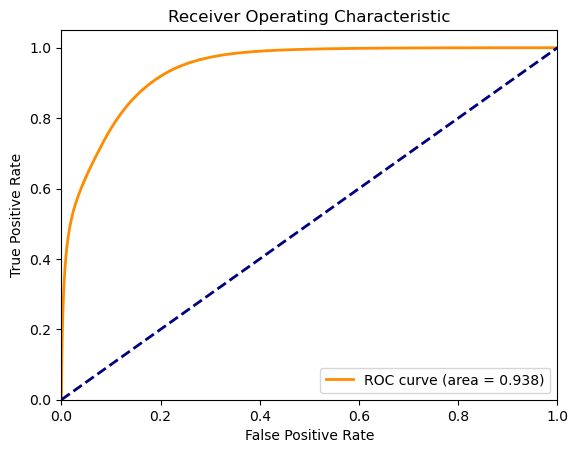

In [8]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def model_outputs(features, model):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        inputs = torch.tensor(features, dtype=torch.float32).to(device)
        outputs = model(inputs).squeeze().cpu().numpy()
    return outputs

# Calculate model outputs
probabilities = model_outputs(filtered_inputs, model)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(filtered_labels, probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2  # Line width
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

/tmp/ipykernel_2126127/52354147.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(features, dtype=torch.float32).to(device)


Prediction scores for displaced tracks (t5_sim_vxy > 0.1):
Mean score: 0.8431
Median score: 0.9289


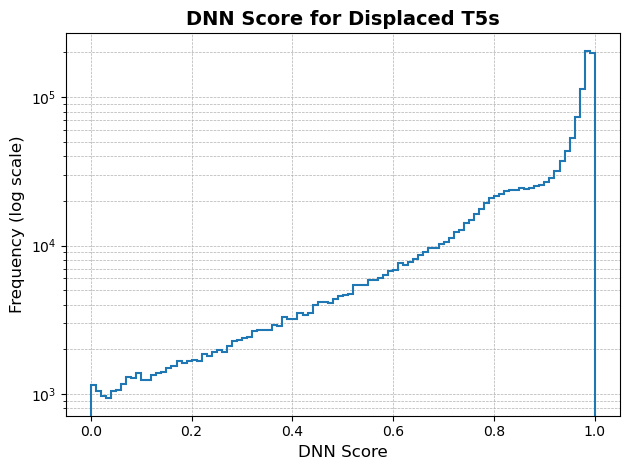

In [9]:
# Get model predictions
probabilities = model_outputs(input_features_tensor, model)

# Get displaced track mask
displaced_mask = np.concatenate(branches['t5_sim_vxy'])[~nan_mask] > 0.1

# Calculate statistics for displaced tracks
displaced_predictions = probabilities[displaced_mask]
mean_score = np.mean(displaced_predictions)
median_score = np.median(displaced_predictions)

print(f"Prediction scores for displaced tracks (t5_sim_vxy > 0.1):")
print(f"Mean score: {mean_score:.4f}")
print(f"Median score: {median_score:.4f}")

plt.hist(displaced_predictions, bins=100, histtype='step', linewidth=1.5)  # Outline only, no fill
plt.yscale('log')
plt.xlabel("DNN Score", fontsize=12)
plt.ylabel("Frequency (log scale)", fontsize=12)
plt.title("DNN Score for Displaced T5s", fontsize=14, weight='bold')

plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [10]:
def print_formatted_weights_biases(weights, biases, layer_name):
    # Print biases
    print(f"ALPAKA_STATIC_ACC_MEM_GLOBAL const float bias_{layer_name}[{len(biases)}] = {{")
    print(", ".join(f"{b:.7f}f" for b in biases) + " };")
    print()

    # Print weights
    print(f"ALPAKA_STATIC_ACC_MEM_GLOBAL const float wgtT_{layer_name}[{len(weights[0])}][{len(weights)}] = {{")
    for row in weights.T:
        formatted_row = ", ".join(f"{w:.7f}f" for w in row)
        print(f"{{ {formatted_row} }},")
    print("};")
    print()

def print_model_weights_biases(model):
    # Make sure the model is in evaluation mode
    model.eval()

    # Iterate through all named modules in the model
    for name, module in model.named_modules():
        # Check if the module is a linear layer
        if isinstance(module, nn.Linear):
            # Get weights and biases
            weights = module.weight.data.cpu().numpy()
            biases = module.bias.data.cpu().numpy()

            # Print formatted weights and biases
            print_formatted_weights_biases(weights, biases, name.replace('.', '_'))

print_model_weights_biases(model)


ALPAKA_STATIC_ACC_MEM_GLOBAL const float bias_layer1[32] = {
1.9492974f, 0.0396722f, -0.0478556f, -2.8262513f, 0.1252225f, -0.0113276f, -0.8949825f, 0.8136070f, 2.5438459f, -0.9275875f, -0.0938528f, -2.3238945f, 2.1461618f, 1.1698613f, 0.0408646f, -0.4878817f, -0.1801908f, -0.1614981f, -3.1146274f, 0.0678447f, -0.3607247f, 0.0346919f, -0.0245114f, -0.1123977f, -0.0943472f, 0.1704714f, 0.5080858f, -0.0382601f, -1.6657745f, -0.0754868f, 0.0311479f, -2.3198860f };

ALPAKA_STATIC_ACC_MEM_GLOBAL const float wgtT_layer1[23][32] = {
{ -3.0399308f, -0.0915596f, -0.2095378f, -0.4057799f, 0.0920423f, 0.0273098f, 0.1332396f, -0.7273244f, -2.6520557f, 0.3655261f, -0.1080886f, -1.3568549f, -1.1831012f, -1.9368840f, -0.0804713f, 0.3882719f, -0.1703173f, 0.0251815f, -1.7169623f, 0.0874820f, -0.9232026f, 0.0469656f, 0.0611625f, -0.2046249f, -0.0228281f, -1.9765152f, 1.6918147f, -0.4028045f, 2.1379662f, 0.2229476f, 0.0063945f, -1.8580508f },
{ -0.0099532f, 0.0032592f, -0.0076483f, -0.0240674f, -0.02654

In [11]:
# Ensure input_features_tensor is moved to the appropriate device
input_features_tensor = input_features_tensor.to(device)

# Make predictions
with torch.no_grad():
    model.eval()
    outputs = model(input_features_tensor)
    predictions = outputs.squeeze().cpu().numpy()

full_tracks = (np.concatenate(branches['t5_isFake']) == 0) * (np.concatenate(branches['t5_pMatched']) > 0.95)

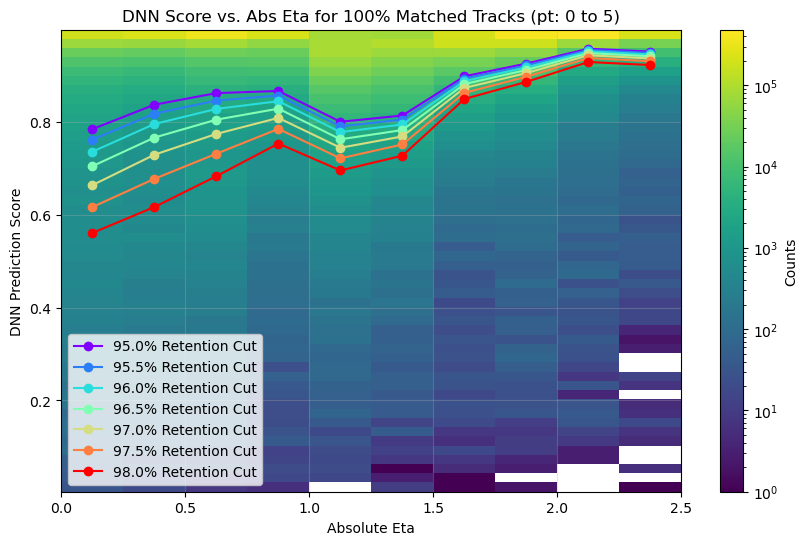


pt: 0 to 5
95.0% Retention Cut: {0.785, 0.8376, 0.8626, 0.8672, 0.8008, 0.8143, 0.8988, 0.9263, 0.9583, 0.9521} Mean: 0.8703
95.5% Retention Cut: {0.7625, 0.8183, 0.8466, 0.8573, 0.7908, 0.8056, 0.8938, 0.9224, 0.9557, 0.9493} Mean: 0.8602
96.0% Retention Cut: {0.7363, 0.796, 0.8286, 0.8452, 0.7786, 0.7949, 0.8885, 0.9179, 0.9526, 0.9459} Mean: 0.8485
96.5% Retention Cut: {0.7051, 0.7667, 0.8053, 0.8291, 0.763, 0.7829, 0.8821, 0.9125, 0.9489, 0.942} Mean: 0.8338
97.0% Retention Cut: {0.6642, 0.7298, 0.7747, 0.8092, 0.7447, 0.7692, 0.8737, 0.9058, 0.9443, 0.9372} Mean: 0.8153
97.5% Retention Cut: {0.6169, 0.6777, 0.732, 0.7854, 0.7219, 0.7518, 0.8632, 0.8979, 0.9382, 0.9314} Mean: 0.7917
98.0% Retention Cut: {0.5612, 0.617, 0.6835, 0.7539, 0.6958, 0.7277, 0.85, 0.8869, 0.9297, 0.9231} Mean: 0.7629


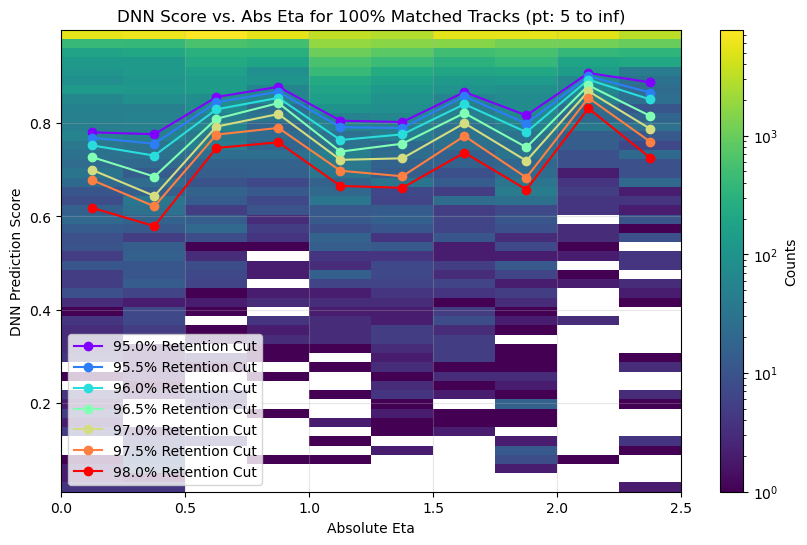


pt: 5 to inf
95.0% Retention Cut: {0.7801, 0.7762, 0.8557, 0.8777, 0.8051, 0.8023, 0.8664, 0.8164, 0.9072, 0.8871} Mean: 0.8374
95.5% Retention Cut: {0.7685, 0.7558, 0.8444, 0.8672, 0.7911, 0.7894, 0.8575, 0.7988, 0.9004, 0.8653} Mean: 0.8238
96.0% Retention Cut: {0.752, 0.7302, 0.8294, 0.8541, 0.7637, 0.7758, 0.8405, 0.7806, 0.8929, 0.8505} Mean: 0.807
96.5% Retention Cut: {0.7268, 0.6853, 0.8091, 0.8428, 0.7389, 0.7558, 0.8214, 0.748, 0.8808, 0.815} Mean: 0.7824
97.0% Retention Cut: {0.6994, 0.6439, 0.7924, 0.8193, 0.7212, 0.7245, 0.7997, 0.7191, 0.8683, 0.7874} Mean: 0.7575
97.5% Retention Cut: {0.6776, 0.6215, 0.7752, 0.7896, 0.6978, 0.686, 0.7723, 0.6831, 0.854, 0.7598} Mean: 0.7317
98.0% Retention Cut: {0.6182, 0.5792, 0.7467, 0.7588, 0.6653, 0.6613, 0.7365, 0.6575, 0.8317, 0.7253} Mean: 0.698


In [12]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

def plot_for_pt_bin(pt_min, pt_max, percentiles, eta_bin_edges, eta_list, predictions, full_tracks, branches):
    """
    Calculate and plot cut values for specified percentiles in a given pt bin
    
    Parameters:
    -----------
    pt_min : float
        Minimum pt value for the bin
    pt_max : float
        Maximum pt value for the bin
    percentiles : list
        List of percentiles to calculate (e.g., [92.5, 96.7, 99])
    eta_bin_edges : array
        Edges of the eta bins
    eta_list : list
        List of eta values
    predictions : array
        Array of DNN predictions
    full_tracks : array
        Boolean array for track selection
    branches : dict
        Dictionary containing branch data
    """
    # Filter data based on pt bin
    abs_eta = eta_list[0][full_tracks & (np.concatenate(branches['t5_pt']) > pt_min) & 
                         (np.concatenate(branches['t5_pt']) <= pt_max)]
    predictions_filtered = predictions[full_tracks & (np.concatenate(branches['t5_pt']) > pt_min) & 
                                    (np.concatenate(branches['t5_pt']) <= pt_max)]
    
    # Dictionary to store cut values for different percentiles
    cut_values = {p: [] for p in percentiles}

    # Loop through each eta bin
    for i in range(len(eta_bin_edges) - 1):
        # Get indices of tracks within the current eta bin
        bin_indices = (abs_eta >= eta_bin_edges[i]) & (abs_eta < eta_bin_edges[i + 1])
        
        # Get the corresponding DNN prediction scores
        bin_predictions = predictions_filtered[bin_indices]
        
        # Calculate the percentile cut values for the current bin
        for percentile in percentiles:
            cut_value = np.percentile(bin_predictions, 100 - percentile)  # Convert retention to percentile
            cut_values[percentile].append(cut_value)

    # Plot 2D histogram
    plt.figure(figsize=(10, 6))
    plt.hist2d(abs_eta, predictions_filtered, bins=[eta_bin_edges, 50], norm=LogNorm())
    plt.colorbar(label='Counts')
    plt.xlabel("Absolute Eta")
    plt.ylabel("DNN Prediction Score")
    plt.title(f"DNN Score vs. Abs Eta for 100% Matched Tracks (pt: {pt_min} to {pt_max})")

    # Plot the cut values with different colors
    cut_x = eta_bin_edges[:-1] + (eta_bin_edges[1] - eta_bin_edges[0]) / 2  # Mid-points of the bins
    colors = plt.cm.rainbow(np.linspace(0, 1, len(percentiles)))  # Generate distinct colors
    
    for percentile, color in zip(percentiles, colors):
        plt.plot(cut_x, cut_values[percentile], '-', color=color, marker='o', 
                label=f'{percentile}% Retention Cut')
    
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Print the cut values
    print(f"\npt: {pt_min} to {pt_max}")
    for percentile in percentiles:
        values = cut_values[percentile]
        print(f"{percentile}% Retention Cut:", 
              '{' + ', '.join(str(x) for x in np.round(values, 4)) + '}',
              "Mean:", np.round(np.mean(values), 4))

# Example usage:
def analyze_pt_bins(pt_bins, percentiles, eta_bin_edges, eta_list, predictions, full_tracks, branches):
    """
    Analyze and plot for multiple pt bins and percentiles
    
    Parameters:
    -----------
    pt_bins : list
        List of pt bin edges
    percentiles : list
        List of percentiles to calculate
    Other parameters same as plot_for_pt_bin function
    """
    for i in range(len(pt_bins) - 1):
        plot_for_pt_bin(pt_bins[i], pt_bins[i + 1], percentiles, eta_bin_edges, 
                       eta_list, predictions, full_tracks, branches)

# Example call:
percentiles = np.arange(95, 98.5, 0.5)
pt_bins = [0, 5, np.inf]
eta_bin_edges = np.arange(0, 2.75, 0.25)
analyze_pt_bins(pt_bins, percentiles, eta_bin_edges, eta_list, predictions, full_tracks, branches)